# STEAM games - a case study on their marketing strategy.

### Why are STEAM games so popular? How do they manage to maintain their player base? This case study aims to analyse how they promote their games to increase revenue

In [87]:
import pandas as pd
import matplotlib.pyplot as plt 
import collections
from wordcloud import WordCloud
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [88]:
# We will be analysing a steam games dataset. Importing dataframe. 

steam = pd.read_csv('steam.csv')

In [89]:
# And creating a copy

df=steam.copy()

#This is the information we start with

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27074 non-null  object 
 5   publisher         27061 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [90]:
# To analyse net total ratings per game, we need to add the relevant columns
# We will also use net rating and mean owners per game to estimate average revenue

df['net_rating'] = df['positive_ratings']-df['negative_ratings']

def own_av(owners):
    a=owners.split('-')
    return int((int(a[0])+int(a[1]))/2)

df['owners_mean'] = df['owners'].apply(own_av)
df['revenue'] = df['price']*df['owners_mean']

In [91]:
# We also need to separate game ratings into net positive, neutral and net negative.
# We do this by subtracting the negative rating from the positive in each game.

pos_rat = len(df[df['net_rating'] > 0])
zero_rat = len(df[df['net_rating'] == 0])
neg_rat = len(df[df['net_rating'] < 0])

# A Dataframe is then created so this can be analyzed

ratings = pd.DataFrame()
ratings['ratings']=[pos_rat, zero_rat,neg_rat]
ratings['']=['positive','neutral','negative']
ratings.set_index('', inplace=True)

In [92]:
ratings

,ratings
,
positive,21923
neutral,916
negative,4236


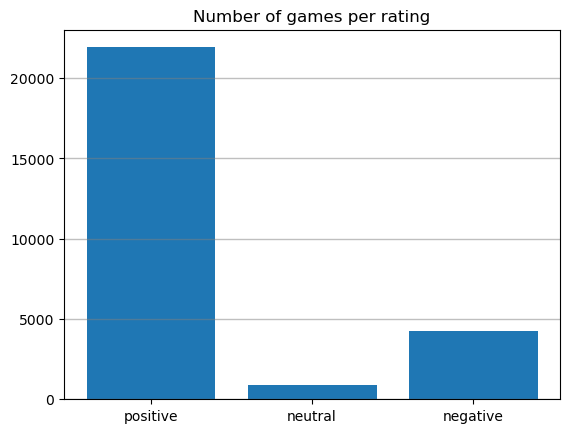

In [131]:
# Analyzing reception of steam games. As we can see, it is overwhelmingly positive. 
# Why are Steam games so successful?

plt.bar(['positive','neutral','negative'],ratings['ratings'])
plt.title('Number of games per rating')
plt.grid(color='grey', linestyle='-', linewidth=1.0, axis='y', alpha=0.5);


In [94]:
# What are they publishing?
# Let's look at genre tags. Looking at the Series, some games have multiple tags

df['genres'].sample(5)

23657                  Casual;Indie;Strategy
8465     Adventure;Free to Play;RPG;Strategy
15729                    Action;Casual;Indie
2681                            Action;Indie
4743                            Action;Indie
Name: genres, dtype: object

In [95]:
# to count these individually, we need first to convert to list

genres = df['genres'].tolist()

#split the values into single entries, and convert the new list into a dataframe

a=[]
for i in genres:
    a = a + i.split(';')
a= pd.DataFrame(a)


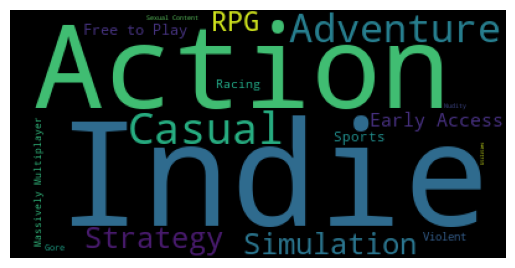

In [96]:
#We then use this dataframe to count frequencies and print a wordcloud. 
# We can clearly see the most common genres are indie and action
# With Casual coming close third

data = a[0].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data)

plt.imshow(wc)
plt.axis('off')
plt.show()

In [97]:
# So what revenue are tey actually getting from these games?
# To find out, we grab the dictionary with genre info and create a new dataframe

gen_rev = pd.DataFrame.from_dict(data,orient='index')
gen_rev.reset_index(inplace=True)
gen_rev.rename(columns={0:'n_games','index':'genres'}, inplace=True)

In [98]:
# And figure out revenue for each genre, adding it to the gen_rev dataframe

c=0
gen_rev['gen_rev']= 0

for g in range(len(gen_rev['genres'])):             # captures all the unique genres from the gen_rev dataframe
    for n in range(len(df['genres'])):              # captures each instance of genres in the main dataframe (df)
        if gen_rev['genres'][g] in df['genres'][n]: # if the unique genre is in the df cell
            c=c+df['revenue'][n]                    # add the revenue for that cell
    gen_rev['gen_rev'][g] = c                       # update dataframe
    c = 0                                           # and reset revenue counter


In [99]:
# We then sort the values ...

gen_rev.sort_values('gen_rev', ascending = False, inplace=True)

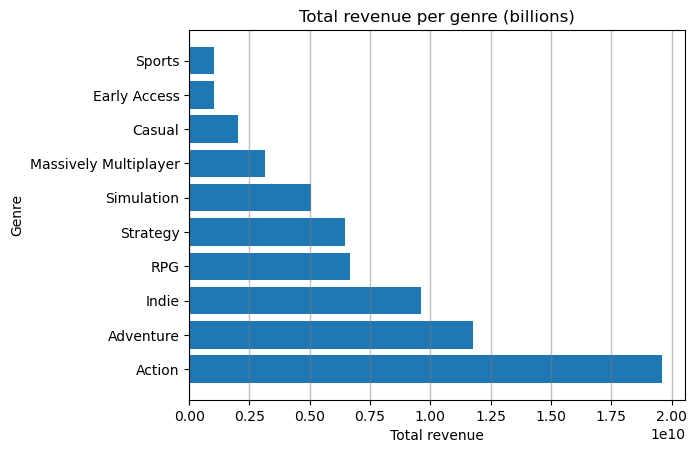

In [133]:
# ... so we can show them in a horizontal bar graph. 
# Top ten was chosen because these are the ones with the highest revenue.
# It's clear Action Adventure and Indie have the highest revenue
# But genres aren't mutually excusive 
# so further analysis on this needs to take that into account

plt.barh(gen_rev['genres'].head(10).tolist(), gen_rev['gen_rev'].head(10).tolist())
plt.xlabel('Total revenue')
plt.ylabel('Genre')
plt.title('Total revenue per genre (billions)')
plt.grid(color='grey', linestyle='-', linewidth=1.0, axis='x', alpha=0.5);

In [101]:
# We can see Casual games provide little revenue, so why invest in them?
# To know this, we first try to find out how many games have single vs many genre identifiers
# We create a function to test this

def gen_check(s):
    gen = gen_rev['genres'].tolist()
    if s in gen:
        b = True
    else: b = False
    return b

In [102]:
# And apply it to the genres column

df['gen_unique'] = df['genres'].apply(gen_check)

In [103]:
# We then create a new dataframe with only multiple identifiers

df_cas = df[df['gen_unique'] == False]

In [104]:
# And calculate how many of each single and multiple identifiers 
# there are

many = len(df_cas)
single = len(df) - many

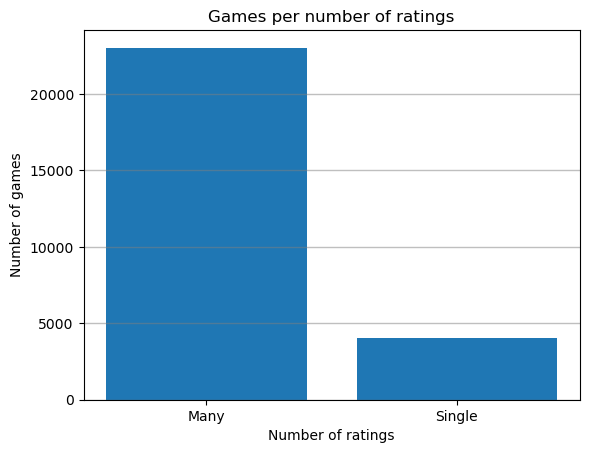

In [135]:
# And plot it
# We can see the vast majority of games have more than one genre
# but is this still true for casual games?

names = ['Many','Single']
values = [many,single]


x = np.array(['Many','Single'])
y = np.array([many,single])

plt.bar(x,y)
plt.xlabel('Number of ratings')
plt.ylabel('Number of games')
plt.title('Games per number of ratings')
plt.grid(color='grey', linestyle='-', linewidth=1.0, axis='y', alpha=0.5);
plt.show()

In [106]:
# To find out, we create a new dataframe for casual games
# showing us the total number of games that are casual
# how many have that single tag, and how many have more than one

casual_unique = len(df[df['genres'] == 'Casual'])
casual_total = gen_rev[gen_rev['genres'] == 'Casual']
casual_total['gen_rev']=casual_unique
casual_total.rename(columns={'n_games': 'total games', 'gen_rev': 'unique'}, inplace=True)
casual_total['many']=casual_total['total games'] - casual_total['unique']
casual_total

,genres,total games,unique,many
2,Casual,10210,560,9650


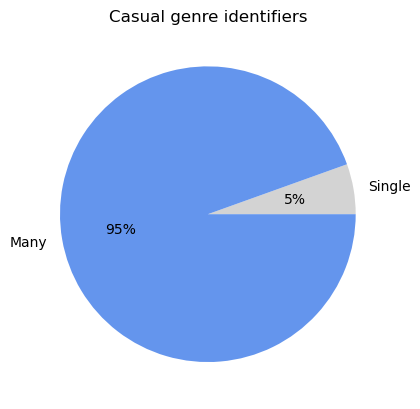

In [153]:
# Comparing single vs many labels for Casual games
# we can see most of them have multiple tags

labels = 'Single','Many'
sizes = [560,9650]

plt.title('Casual genre identifiers')
plt.pie(sizes, labels=labels,autopct='%.0f%%', colors=['lightgray','cornflowerblue']);

In [108]:
# But this in itself isn't uncommon, as we have already seen
# What other tags are included with the casual one?
# First we create a new function to test whether Casual is present 
# in a cell of the dataframe with all the multiple identifiers

def gen_cas(s):
    if 'Casual' in s:
        b = True
    else: b = False
    return b


In [109]:
# And apply it to the genres columns

df_cas['cas_many'] = df_cas['genres'].apply(gen_cas)

In [110]:
# We then select only the rows that have Casual in them

df_cas_many = df_cas[df_cas['cas_many'] == True]

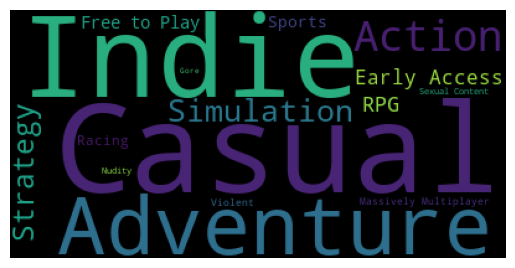

In [111]:
# And then follow the same process to create a wordcloud for these genres, same as before
# Again, value counts for the categories

cas_many = df_cas_many['genres'].tolist()

# Split the values into single entries, and convert the new list into a dataframe

a=[]
for i in cas_many:
    a = a + i.split(';')
a= pd.DataFrame(a)

# And then use this dataframe to count frequencies and print a wordcloud. 

data = a[0].value_counts().to_dict()
wc = WordCloud().generate_from_frequencies(data)

plt.imshow(wc)
plt.axis('off')
plt.show()

In [112]:
# The tags most used with Casual are Indie and Adventure
# two of the highest revenue genres, which suggests
# Indie adventure games are a great way to target the casual player cohort